In [17]:
import model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# run single model 
scenario = model.CounterterrorismModel(N=200, height=3,width=4,prob_violence=0.0001,policy='NONE',reactive_lvl='none',discontent='mid')
for i in range(200):
    scenario.step()

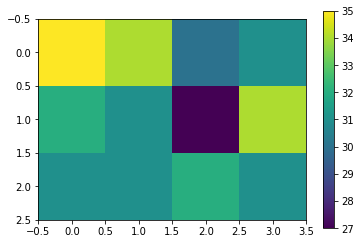

In [3]:
# plot number of agents remaining in each cell in the model
agent_counts = np.zeros((scenario.grid.width, scenario.grid.height))
for cell in scenario.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count

plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

<AxesSubplot:>

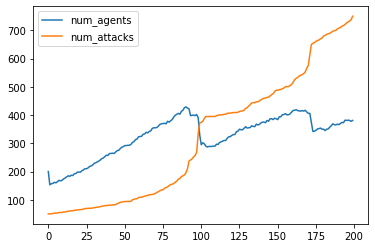

In [4]:
# plot number of agents and number of attacks over time 
model_df = scenario.datacollector.get_model_vars_dataframe()
model_df.plot()

In [5]:
model_df.head()

,num_agents,num_attacks
0,200,50
1,153,50
2,157,51
3,158,51
4,162,53


In [6]:
# write to csv for future analysis
model_df.to_csv('model_df.csv')

In [6]:
# get dataframe of all agents (citizens and government) with status and location each step
agents_df = scenario.datacollector.get_agent_vars_dataframe()
agents_df.head()

status agent_loc
Step AgentID                         
1    1              neutral    (0, 2)
     2        anti-violence    (0, 0)
     3              neutral    (2, 2)
     4              neutral    (2, 0)
     5            combatant    (1, 0)

In [7]:
# get nongovernmental agents
agents_df = agents_df.reset_index()
agents_nogov_df = agents_df[agents_df.status.isin(['anti-violence','combatant','neutral','sympathetic'])]

agents_nogov_df.head()

,Step,AgentID,status,agent_loc
0,1,1,neutral,"(0, 2)"
1,1,2,anti-violence,"(0, 0)"
2,1,3,neutral,"(2, 2)"
3,1,4,neutral,"(2, 0)"
4,1,5,combatant,"(1, 0)"


In [8]:
# group agents by status and count at each step
agents_nogov_df['step_cat'] = agents_nogov_df.Step.astype('str')
agent_stati_gb = agents_nogov_df.groupby(by=['step_cat','status'])
agent_stati = agent_stati_gb['AgentID'].nunique().reset_index()
agent_stati = agent_stati.rename(columns={'AgentID':'num_agents'})
agent_stati['step'] = agent_stati.step_cat.astype('int')
agent_stati.head()

/tmp/ipykernel_759/1079145666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agents_nogov_df['step_cat'] = agents_nogov_df.Step.astype('str')


,step_cat,status,num_agents,step
0,1,anti-violence,67,1
1,1,combatant,50,1
2,1,neutral,46,1
3,1,sympathetic,37,1
4,10,anti-violence,99,10


In [9]:
# begin gathering dataframe of the dominant sentiment per location per step
max_sent_gb = agents_nogov_df.groupby(by=['step_cat','agent_loc','status'])
sentiments_cnt = max_sent_gb['AgentID'].nunique().reset_index()
sentiments_cnt = sentiments_cnt.rename(columns={'AgentID':'num_agents'})
sentiments_cnt.head()

,step_cat,agent_loc,status,num_agents
0,1,"(0, 0)",anti-violence,8
1,1,"(0, 0)",combatant,7
2,1,"(0, 0)",neutral,5
3,1,"(0, 0)",sympathetic,4
4,1,"(0, 1)",anti-violence,7


In [10]:
# complete dataframe of the dominant sentiment per location per step
max_sentiments_gb = sentiments_cnt.groupby(by=['step_cat','agent_loc'])
max_sentiments = max_sentiments_gb['num_agents'].max().reset_index()
print('max sent shape',max_sentiments.shape)
max_sentiments = max_sentiments.merge(sentiments_cnt, on=['step_cat','agent_loc','num_agents'])
max_sentiments.head()

max sent shape (2400, 3)


,step_cat,agent_loc,num_agents,status
0,1,"(0, 0)",8,anti-violence
1,1,"(0, 1)",7,anti-violence
2,1,"(0, 1)",7,sympathetic
3,1,"(0, 2)",4,anti-violence
4,1,"(0, 3)",5,anti-violence


In [11]:
# drop when multiple stati are equally dominant in a location and step
# currently randomly dropping; in future should prioritize according to hierarchy
# of most influential (combatant -> sympathetic -> neutral -> anti-violence?) 
# code beginning to do this below
max_sents_nodups = max_sentiments.drop_duplicates(subset=['step_cat','agent_loc','num_agents'])
max_sents_nodups['step'] = max_sents_nodups.step_cat.astype('int')

/tmp/ipykernel_759/915764481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_sents_nodups['step'] = max_sents_nodups.step_cat.astype('int')


-----------------------
Ignore code between these lines - initial work to remove duplicates according to hierarchy; to be implemented at a later date.

In [12]:
max_sents_nodups = max_sentiments.drop_duplicates(subset=['step_cat','agent_loc','num_agents'],keep=False)
max_sents_nodups.head()

,step_cat,agent_loc,num_agents,status
0,1,"(0, 0)",8,anti-violence
3,1,"(0, 2)",4,anti-violence
4,1,"(0, 3)",5,anti-violence
5,1,"(1, 0)",9,neutral
6,1,"(1, 1)",8,anti-violence


In [13]:
max_sents_dups = max_sentiments[max_sentiments.duplicated(subset=['step_cat','agent_loc','num_agents'],keep=False)]
max_sents_dups.head()

,step_cat,agent_loc,num_agents,status
1,1,"(0, 1)",7,anti-violence
2,1,"(0, 1)",7,sympathetic
11,1,"(2, 2)",5,anti-violence
12,1,"(2, 2)",5,combatant
13,1,"(2, 2)",5,neutral


In [15]:
hierarchy = ['combatant','sympathetic','neutral','anti-violence']
for dup_step in max_sents_dups.step_cat.unique():
    #print('dup step',dup_step)
    to_dedup = max_sents_dups[max_sents_dups.step_cat == dup_step]
    #print('to dedup stati',to_dedup.status.unique())
    for hier_status in hierarchy:
        #print('considering status',hier_status)
        if hier_status in to_dedup.status.unique():
            max_sents_nodups.append(to_dedup[to_dedup.status == hier_status])
            break

End of code starting to drop duplicates by hierarchy; end of code to disregard.   
  
-------------------------------------------

In [16]:
# create dataframe of only citizen actions to save
agents_df['step_cat'] = agents_df.Step.astype('str')
agent_stati_gb = agents_df.groupby(by=['step_cat','status'])
agent_stati = agent_stati_gb['AgentID'].nunique().reset_index()
agent_stati = agent_stati.rename(columns={'AgentID':'num_agents'})
agent_stati['step'] = agent_stati.step_cat.astype('int')

palestinian_stati = agent_stati[agent_stati.status.isin(['anti-violence','combatant','neutral','sympathetic'])]
palestinian_stati.head()

,step_cat,status,num_agents,step
1,1,anti-violence,67,1
2,1,combatant,50,1
3,1,neutral,46,1
4,1,sympathetic,37,1
6,10,anti-violence,99,10


In [32]:
palestinian_stati.to_csv('palestinian_stati.csv')

<AxesSubplot:xlabel='step', ylabel='num_agents'>

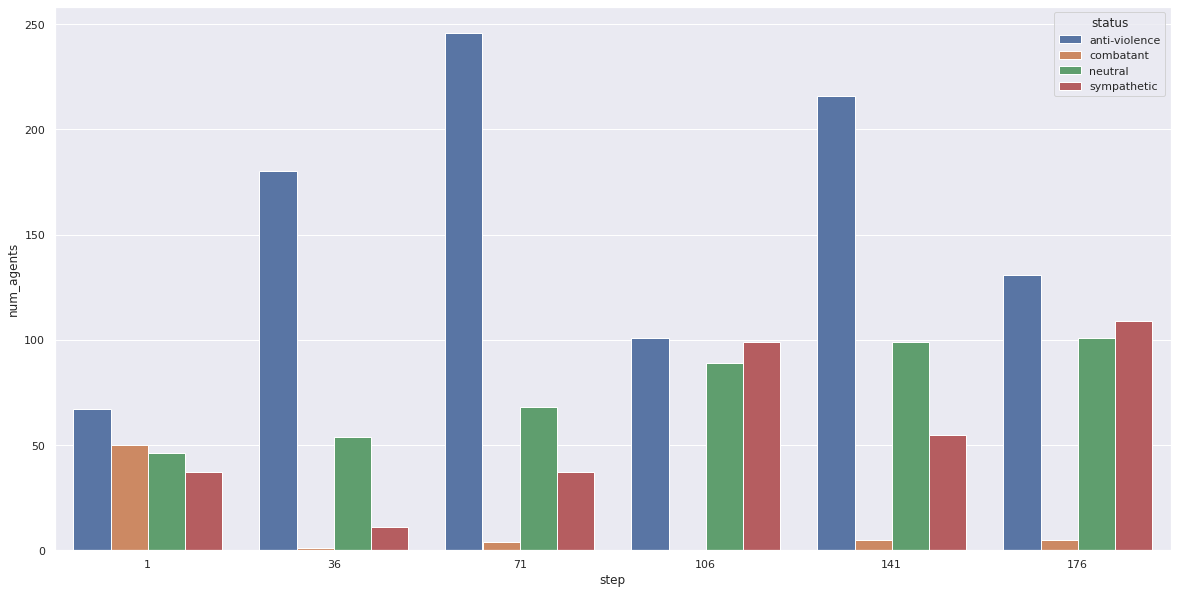

In [18]:
# show number of citizens of each status at each step in the simulation
sns.set(style='darkgrid')
plt.figure(figsize=(20,10))

sns.barplot(x='step',y='num_agents',hue='status',data=palestinian_stati[palestinian_stati.step.isin(range(1,700,round(700*0.05)))])

anti-violence
neutral
anti-violence
neutral
anti-violence
neutral
neutral
anti-violence
sympathetic
neutral
sympathetic
anti-violence


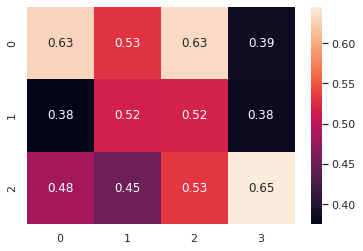

In [19]:
# create heatmap of percent of citizens who are of the dominant sentiment per cell
dominant_sentiments = np.zeros((scenario.grid.width, scenario.grid.height))
dominant_sentiments = dominant_sentiments.astype(str)
dominant_sentiments[dominant_sentiments=='0.0'] = 'none'
percent_dominant_sentiments = np.zeros((scenario.grid.width, scenario.grid.height))

for cell in scenario.grid.coord_iter():
    cell_content, x, y = cell
    status_dict = {'anti-violence':0,'NONE':0,'neutral':0,'sympathetic':0,\
        'combatant':0,'TARG-CONC':0,'TARG-REPR':0,'INDISC-CONC':0,'INDISC-REPR':0}
    for agent in cell_content:
        status_dict[agent.status] += 1

    dominant_sentiment =  max(status_dict, key = lambda x: status_dict[x])
    print(dominant_sentiment)
    if len(cell_content) > 0:
        perc_dominant_sentiment = max(status_dict.values())/len(cell_content)
    else:
        perc_dominant_sentiment = 0

    dominant_sentiments[x][y] = dominant_sentiment 
    percent_dominant_sentiments[x][y] = perc_dominant_sentiment  
     
ax = sns.heatmap(percent_dominant_sentiments, annot=True)
plt.show()

In [20]:
# show visual representation of dominant sentiments 
dominant_sentiments_df = pd.DataFrame(dominant_sentiments)
dominant_sentiments_df

,0,1,2,3
0,anti-violence,neutral,anti-violence,neutral
1,anti-violence,neutral,neutral,anti-violence
2,sympathetic,neutral,sympathetic,anti-violence


In [21]:
# get unique dominant sentiments to use in below heatmap
# code from stackoverflow
vals_to_int = {j:i for i, j in enumerate(pd.unique(dominant_sentiments.ravel()))}
vals_to_int

{'anti-violence': 0, 'neutral': 1, 'sympathetic': 2}

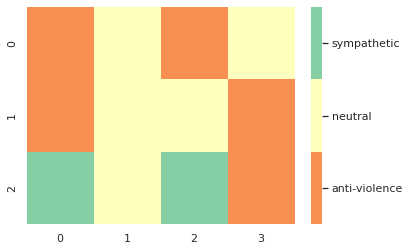

In [22]:
# create heatmap of dominant sentiments per cell
n = len(vals_to_int)
cmap = sns.color_palette('Spectral', n)
ax = sns.heatmap(dominant_sentiments_df.replace(vals_to_int),cmap=cmap)

colorbar = ax.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(vals_to_int.keys()))
plt.show()

In [26]:
# get dataframe of only government actions
govt_status_df = agents_df[agents_df.status.isin(['NONE','INDISC-REPR','INDISC-CONC','TARG-CONC','TARG-REPR'])].reset_index()
govt_status_df.drop('AgentID', axis=1,inplace=True)
govt_status_df = govt_status_df.sort_values('Step',ascending=True)
govt_status_df

,index,Step,status,agent_loc,step_cat
0,200,1,TARG-CONC,"(0, 0)",1
1,351,2,NONE,"(0, 0)",2
2,505,3,TARG-CONC,"(0, 0)",3
3,663,4,NONE,"(0, 0)",4
4,822,5,TARG-REPR,"(0, 0)",5
...,...,...,...,...,...
195,63282,196,TARG-CONC,"(0, 0)",196
196,63664,197,INDISC-REPR,"(0, 0)",197
197,64047,198,NONE,"(0, 0)",198
198,64429,199,TARG-REPR,"(0, 0)",199


In [31]:
# calculate cumulative government actions of each type
govt_status_cum = govt_status_df.groupby(['status']).cumcount()
govt_status_cum = govt_status_cum.rename('cumulative_actions')
govt_status_cum = govt_status_df.join(govt_status_cum)
# cumcount starts at 0, so rise to 1
govt_status_cum['cumulative_actions'] = govt_status_cum['cumulative_actions'] + 1
govt_status_cum.head()

,index,Step,status,agent_loc,step_cat,cumulative_actions
0,200,1,TARG-CONC,"(0, 0)",1,1
1,351,2,NONE,"(0, 0)",2,1
2,505,3,TARG-CONC,"(0, 0)",3,2
3,663,4,NONE,"(0, 0)",4,2
4,822,5,TARG-REPR,"(0, 0)",5,1


In [32]:
# rearrange dataframe for easier display of cumulative counts
govt_status_cum_wide = pd.get_dummies(govt_status_cum['status']).cumsum()
govt_status_cum_wide.head()

,INDISC-CONC,INDISC-REPR,NONE,TARG-CONC,TARG-REPR
0,0,0,0,1,0
1,0,0,1,1,0
2,0,0,1,2,0
3,0,0,2,2,0
4,0,0,2,2,1


<AxesSubplot:xlabel='Step', ylabel='cumulative_actions'>

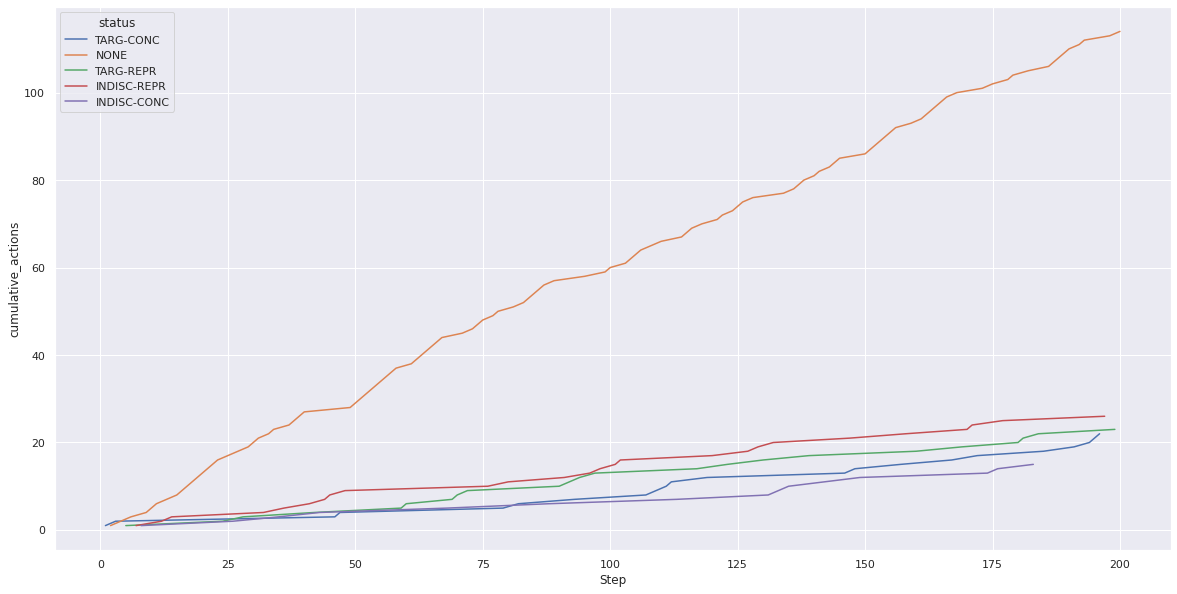

In [34]:
# plot cumulative government actions over time
plt.figure(figsize=(20,10))

sns.lineplot(x='Step',y='cumulative_actions',hue='status',data=govt_status_cum)

In [24]:
# show dataframe of deaths per step
scenario.datacollector.get_table_dataframe('Deaths').head()

,step,deaths
0,1,50
1,2,0
2,3,1
3,4,0
4,5,2


In [25]:
# show dataframe of full government actions over time by location
govt_actions = scenario.datacollector.get_table_dataframe('govt_actions')
govt_actions.head()

,step,govt_action,action_loc,violence_aftermath
0,1,TARG-CONC,"(2, 1)",10
1,2,NONE,"(0, 0)",9
2,3,TARG-CONC,"(0, 3)",10
3,4,NONE,"(0, 0)",9
4,5,TARG-REPR,"(1, 0)",10


In [45]:
govt_actions.to_csv('govt_actions.csv')